# Import libraries

In [1]:
import os
import sys
import json
import csv

# numeric, scientific
from scipy import linalg as spla
import numpy as np

# plotting
%matplotlib inline
import matplotlib
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.pyplot as plt

# import Kitaev Honeycomb package
import kithcmb
from kithcmb import VortexSector as vs
from kithcmb import DisorderVortexSectors as dvs

# import jsci, CT's enhanced json stream write package
import jsci
from jsci import WriteStream as jsciwrite
from jsci import Coding as jscicoding

# Define functions

Plot the real and imaginary parts of a complex matrix next to each other

In [2]:
def draw_real_imag_matrix(matrix_):
    plt.figure( figsize=(18,8) )

    plt.subplot(1, 2, 1)
    plt.imshow( np.real(matrix_).tolist() )
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow( np.imag(matrix_).tolist() )
    plt.colorbar()

    plt.show()

These functions show the spatial support of a given eigenstate over the honeycomb. The probability (mod squared amplitude) of the eigenstate at each black and white site is added together to give a square lattice of sites. 

The final function plots the spatial profile of the two eigenstates that together compose a single mode. (Near the middle of the spectrum, where you get extra degeneracy this might not work right.)

In [3]:
def get_spatial_matrix_elements(full_eigeninfo,state_,site1_,site2_):
    try:
        return ( full_eigeninfo[1][(site2_)][state_]*np.conjugate(full_eigeninfo[1][(site2_)][state_]) + full_eigeninfo[1][site1_][state_]*np.conjugate(full_eigeninfo[1][site1_][state_]) )
    except IndexError:
        print "attempted to access index ",site_," and ",(site_+1)
        raise
    
def draw_spatial_eigenstate(full_eigeninfo,state_):
    spatial_eigenstate = [ [ get_spatial_matrix_elements(full_eigeninfo,state_, ((2*x + 2*L - y)%(2*L) + y*2*L)%(2*L**2) ) for x in range(0,2*L,2) ] for y in range(L) ]
    draw_real_imag_matrix(spatial_eigenstate)
    
def draw_spatial_eigenstate_3d(full_eigeninfo,state_,color_):
    X = [ range(L) for i in range(L) ]
    Y = np.array(X).transpose()
    # TEST = [ [ x for x in range(L) ] for y in range(L) ]
    # spatial_eigenstate = [ [ get_spatial_matrix_elements(full_eigeninfo,state_, ((2*x + 2*L - y)%(2*L) + y*2*L)%(2*L**2) ) for x in range(0,2*L,2) ] for y in range(L) ]
    
    spatial_eigenstate = [ [ 0. for x in range(0,2*L,2) ] for y in range(L) ]
    for y in range(L):
        for x in range(L):
            try:
                site1 = (2*x + 2*L - y)%(2*L) + y*2*L
                site2 = (1+ 2*x + 2*L - y)%(2*L) + y*2*L
                spatial_eigenstate[y][x] = get_spatial_matrix_elements(full_eigeninfo,state_, site1, site2 )
            except IndexError:
                print "error thrown by x : ",x,", y: ",y
                raise
    
    # fig = plt.figure( figsize=(16,10))
    # ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, np.real(spatial_eigenstate).tolist(), color=color_, rstride=1, cstride=1)
    # ax.plot_wireframe(X, Y, TEST, rstride=1, cstride=1)
    # ax.view_init(elev=30., azim=30.)
    
    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.show()

# Set system parameters and initialise 

In [4]:
L = 20
J = 1
kappa = 0.1

In [5]:
kh_sys = vs.VortexSector(L,J,kappa,1)

Print J and u

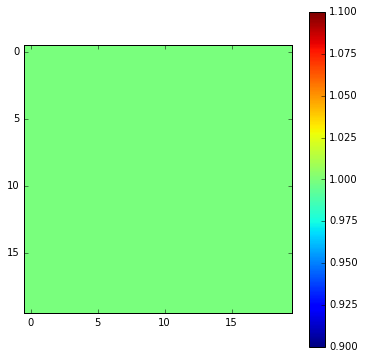

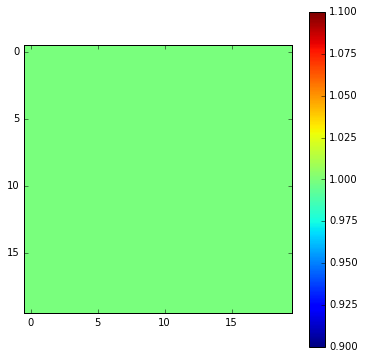

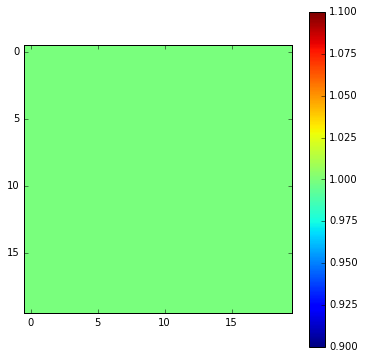

In [6]:
plt.figure( figsize=(6,6) )
plt.imshow(kh_sys.Jx)
plt.colorbar()
plt.show()

plt.figure( figsize=(6,6) )
plt.imshow(kh_sys.Jy)
plt.colorbar()
plt.show()

plt.figure( figsize=(6,6) )
plt.imshow(kh_sys.Jz)
plt.colorbar()
plt.show()

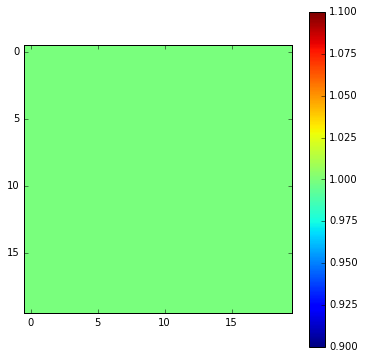

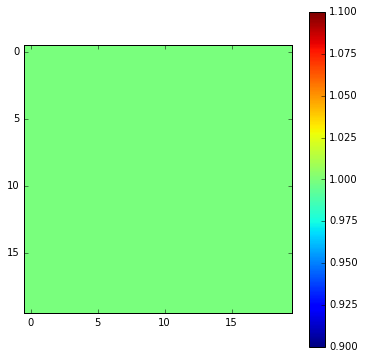

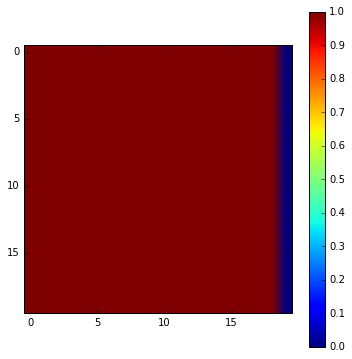

In [7]:
plt.figure( figsize=(6,6) )
plt.imshow(kh_sys.Ux)
plt.colorbar()
plt.show()

plt.figure( figsize=(6,6) )
plt.imshow(kh_sys.Uy)
plt.colorbar()
plt.show()

plt.figure( figsize=(6,6) )
plt.imshow(kh_sys.Uz)
plt.colorbar()
plt.show()

Print the A matrix

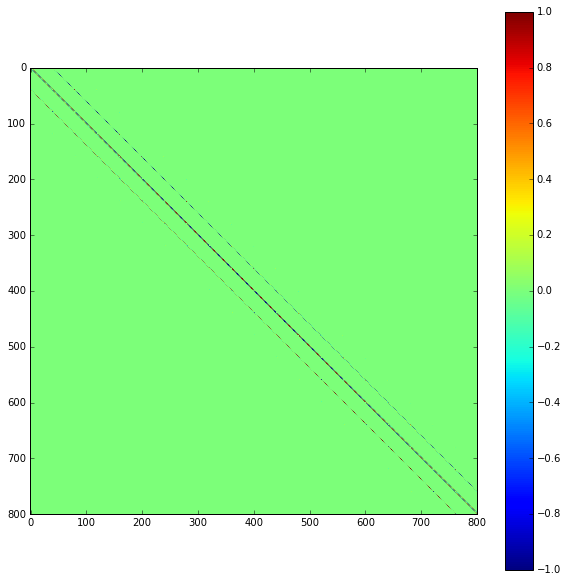

In [8]:
plt.figure( figsize=(10,10) )
plt.imshow(kh_sys.A - np.transpose(kh_sys.A))
plt.colorbar()
plt.show()

Plot the spectrum

In [9]:
kh_sys._update_spectrum()

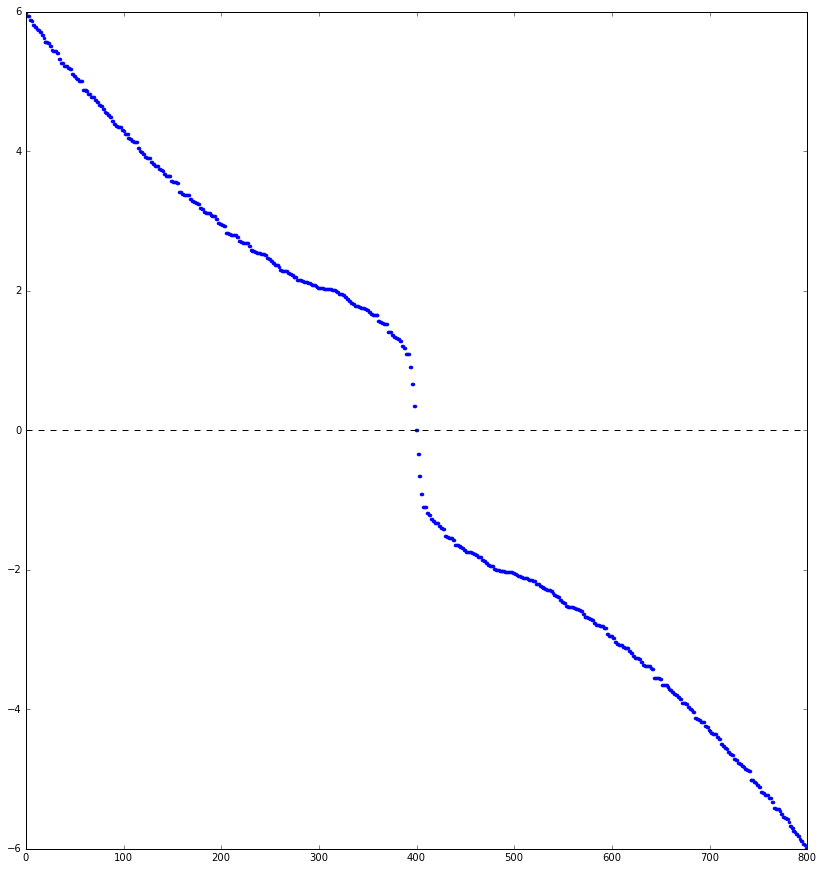

In [10]:
plt.figure( figsize=(14,15) )
plt.plot(kh_sys.spectrum,'.')
plt.plot( range(len(kh_sys.spectrum)), [ 0. for ii in range(len(kh_sys.spectrum)) ], 'k--' )

The spatial profile of some eigenstates

In [11]:
# obtain the eigenvectors
full_eigeninfo = spla.eigh(2j*( kh_sys.A-np.transpose(kh_sys.A) ) )

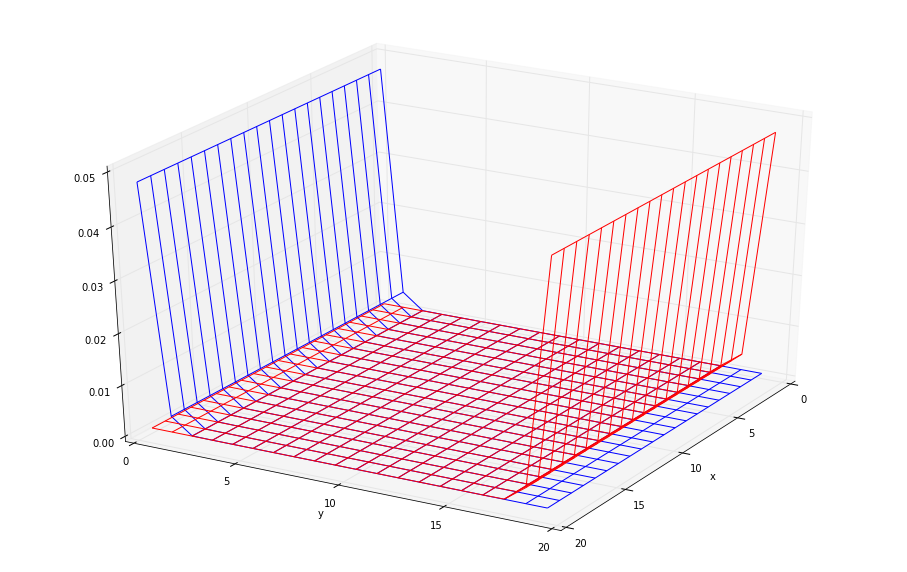

In [12]:
fig = plt.figure( figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

draw_spatial_eigenstate_3d(full_eigeninfo,L**2+2,'b')
draw_spatial_eigenstate_3d(full_eigeninfo,L**2-3,'r')

ax.view_init(elev=30., azim=30.)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Testing edge state detection function for single state against a visualisation of its spatial profile

region A:  (0.138853807741+0j)
region C : (0.28989434482+0j)
True


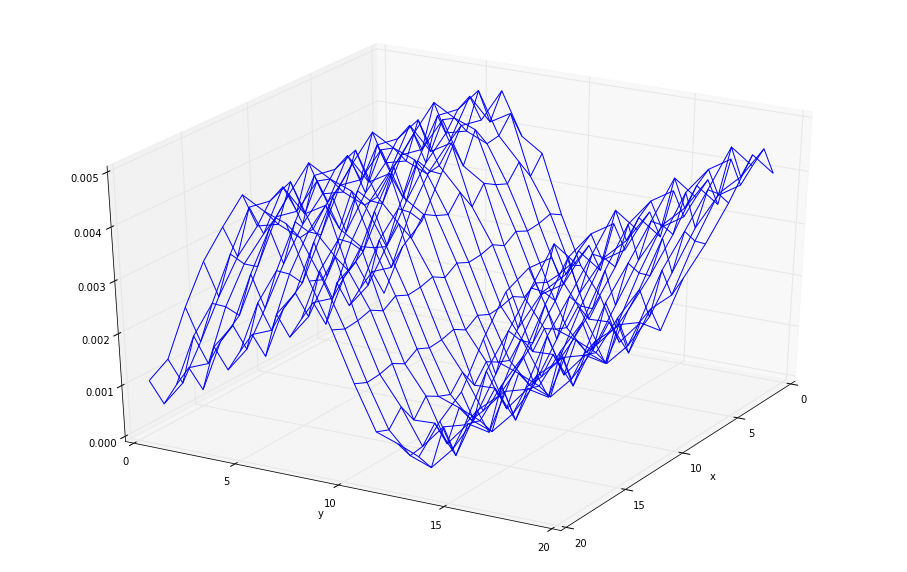

In [13]:
state = kh_sys.L**2-12

print kh_sys.is_state_edge_mode(state)

fig = plt.figure( figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
draw_spatial_eigenstate_3d(full_eigeninfo,state,'b')
ax.view_init(elev=30., azim=30.)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Iterate over all states and identify which are edge states and which are bulk, plot them with different markers to indicate the two types

In [14]:
gap = kh_sys.get_quantity('gap')

In [15]:
edge_states = []
bulk_states = []
for _state in range(len(kh_sys.spectrum)):
    if kh_sys.is_state_edge_mode(_state):
        edge_states.append( _state )
    else:
        bulk_states.append(_state)

region A:  (0.0552216905567+0j)
region C : (0.0552216905567+0j)
region A:  (0.170724134999+0j)
region C : (0.170724134999+0j)
region A:  (0.0552133618713+0j)
region C : (0.055185961386+0j)
region A:  (0.055185961386+0j)
region C : (0.0552133618713+0j)
region A:  (0.170703888914+0j)
region C : (0.170619477217+0j)
region A:  (0.170619477217+0j)
region C : (0.170703888914+0j)
region A:  (0.249169556949+0j)
region C : (0.249169556948+0j)
region A:  (0.249111437838+0j)
region C : (0.249083947403+0j)
region A:  (0.249083947403+0j)
region C : (0.249111437838+0j)
region A:  (0.0552624687304+0j)
region C : (0.0550035525318+0j)
region A:  (0.0550035525317+0j)
region C : (0.0552624687304+0j)
region A:  (0.245051538378+0j)
region C : (0.245051538378+0j)
region A:  (0.170386179919+0j)
region C : (0.17055810595+0j)
region A:  (0.17055810595+0j)
region C : (0.170386179919+0j)
region A:  (0.245002121472+0j)
region C : (0.245030146877+0j)
region A:  (0.245030146877+0j)
region C : (0.245002121472+0j)
re

(-5.9846051066753203, 5.9846051066753176)

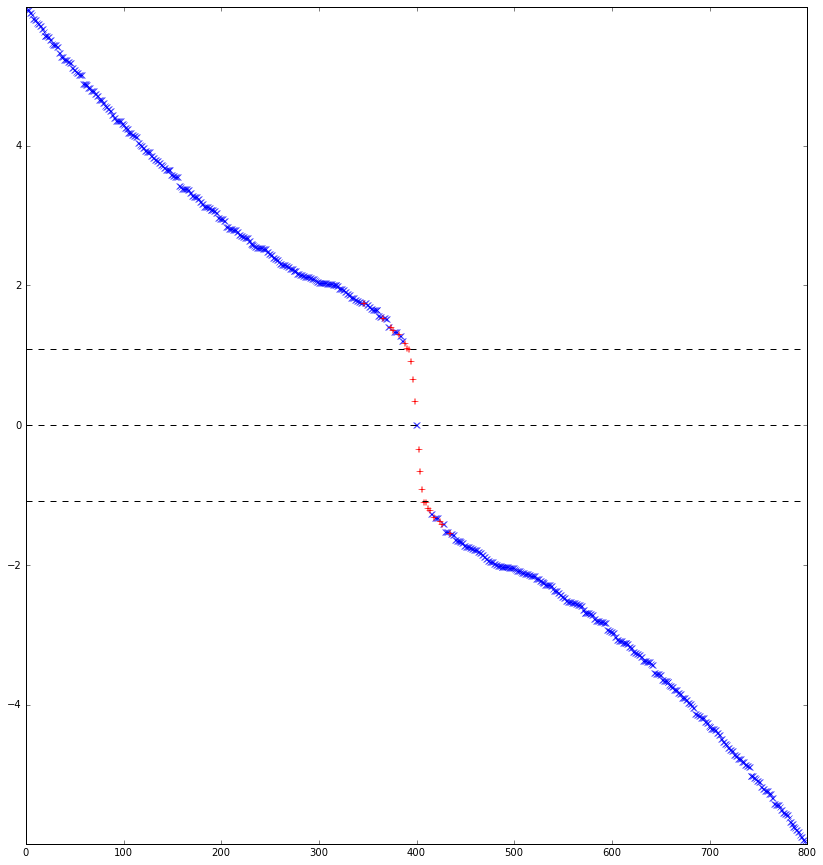

In [16]:
plt.figure( figsize=(14,15) )
plt.plot( bulk_states, [ kh_sys.spectrum[bs] for bs in bulk_states ] ,'bx')
plt.plot( edge_states, [ kh_sys.spectrum[es] for es in edge_states ] ,'r+')

plt.plot( range(len(kh_sys.spectrum)), [ -gap for ii in range(len(kh_sys.spectrum)) ], 'k--' )
plt.plot( range(len(kh_sys.spectrum)), [ 0. for ii in range(len(kh_sys.spectrum)) ], 'k--' )
plt.plot( range(len(kh_sys.spectrum)), [ gap for ii in range(len(kh_sys.spectrum)) ], 'k--' )

plt.ylim( [ min(kh_sys.spectrum),max(kh_sys.spectrum) ] )

## Symmetrise the list about the gap  
The states with indexes (L^2+x) and (L^2-x-1) are paired by part-hole symmetry and if one appears in the list so should the other. If there is a disagreement we remove both of the pair from the list of edge states

In [17]:
print 'L^2 = ',kh_sys.L**2
states_to_remove = []
for es in edge_states:
    if es<kh_sys.L**2:
        # es = (L^2 - x -1)
        x = kh_sys.L**2 - 1 - es
        if not (kh_sys.L**2+x) in edge_states:
            print es,' incuded in list by not ',(kh_sys.L**2+x),' removing ',es
            states_to_remove.append(es)
    else:
        # es = (L^2 + x)
        x = es - kh_sys.L**2
        if not (kh_sys.L**2-x-1) in edge_states:
            print es,' incuded in list by not ',(kh_sys.L**2-x-1),' removing ',es
            states_to_remove.append(es)
            
# remove them from the list of edge states
edge_states = [ es for es in edge_states if es not in states_to_remove ]            

# add these states to the list of bulk states
bulk_states.extend( states_to_remove )

L^2 =  400
345  incuded in list by not  454  removing  345
346  incuded in list by not  453  removing  346
413  incuded in list by not  386  removing  413
414  incuded in list by not  385  removing  414


Old version of the code where we symmetrised by adding states

(-5.9846051066753203, 5.9846051066753176)

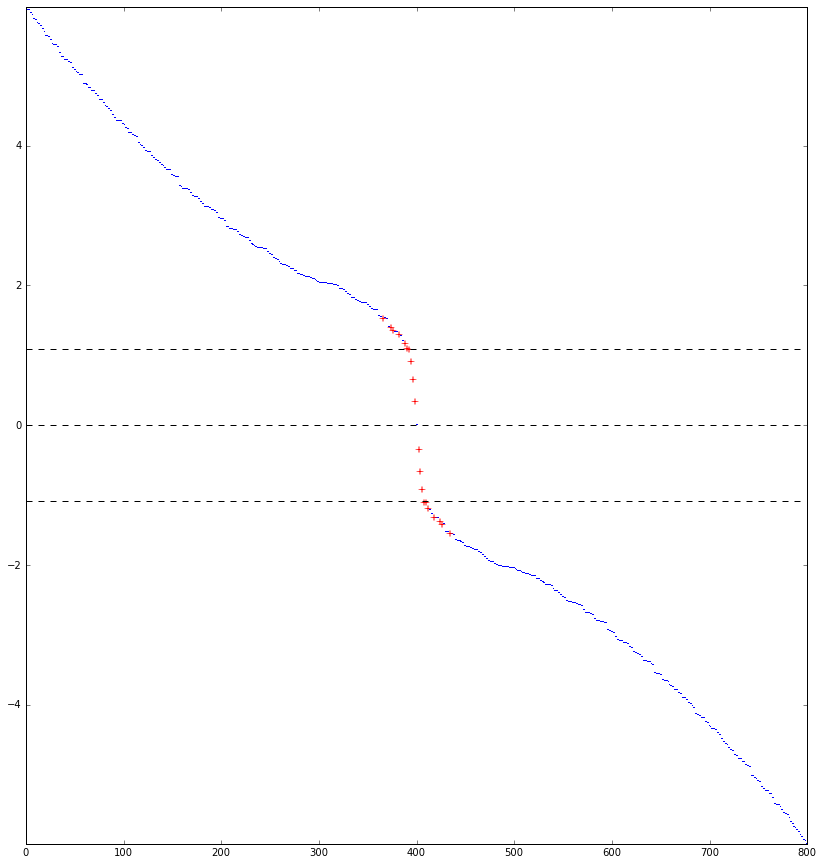

In [18]:
plt.figure( figsize=(14,15) )
plt.plot( bulk_states, [ kh_sys.spectrum[bs] for bs in bulk_states ] ,'b,')
plt.plot( edge_states, [ kh_sys.spectrum[es] for es in edge_states ] ,'r+')
# plt.plot( edge_states, [ -kh_sys.spectrum[es] for es in edge_states ] ,'b.')

plt.plot( range(len(kh_sys.spectrum)), [ -gap for ii in range(len(kh_sys.spectrum)) ], 'k--' )
plt.plot( range(len(kh_sys.spectrum)), [ 0. for ii in range(len(kh_sys.spectrum)) ], 'k--' )
plt.plot( range(len(kh_sys.spectrum)), [ gap for ii in range(len(kh_sys.spectrum)) ], 'k--' )

plt.ylim( [ min(kh_sys.spectrum),max(kh_sys.spectrum) ] )

In [19]:
len(edge_states)

40